# MLOps ZoomCamp Homework 1 

## by Irem Ergun

Link to the homework description: https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/01-intro/homework.md


We start by importing the required libraries and downloading two libraries for reading parquet files. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns

# !pip3 install pyarrow
# !pip3 install fastparquet


### Question 1. 

We read the data into a Pandas dataframe and output the length of the dataframe, which is 1154112 and our answer.

In [2]:
df_jan = pd.read_parquet("../data/fhv_tripdata_2021-01.parquet")
df_jan.head()
print(len(df_jan))

1154112


### Question 2. 

The average trip time is 19 minutes and 10-ish seconds. 

In [3]:
df_jan["duration"] = df_jan["dropOff_datetime"]-df_jan["pickup_datetime"]
df_jan["duration"].mean()

Timedelta('0 days 00:19:10.033445627')

### Data preparation

We convert the duration values to minutes, delete the trips which are shorter than 1 minute and longer than 60 minutes as they are outliers. Now, our dataframe has 1107511 data points, which means that we have removed 46601 of them. 

In [4]:
df_jan["duration_minutes"] = df_jan.duration.apply(lambda td: td.total_seconds() / 60)

df_jan.head()
# df_dup = df_jan #uncomment this line for the bonus part
df_jan =df_jan[(df_jan["duration_minutes"]<=60)&(df_jan["duration_minutes"]>=1)] 

len(df_jan)

1109826

$\textbf{BONUS: not actually a part of the homework}$ 

We were asked to drop the trips that are not between 1 and 60 minutes. However, if we would like to understand why this is the case, here is some code to explore this reasoning. Play around with ```cutoff``` to see how the histogram will change. If you run this cell with line 4 commented out, you will most likely not be able to observe a meaningful histogram since just a few groups will dominate the others in size. That is exactly what we mean when we talk about outliers. 

You can also play around with the ```ran``` variable to group the trimmed dataset into groups of different sizes.

But we observe that if we keep cutoff as 60, we get back a very well structured histogram, which is precisely what we want! Comment out the upcoming three cells and play around with the values as instructed if you wish :) 

In [5]:
# df_temp = df_dup[["duration_minutes","duration"]] 

# cutoff = 60
# # print(df_temp.duration_minutes.describe(percentiles=[0.95,0.98,0.99]))
# df_temp =df_temp[(df_temp["duration_minutes"]<=cutoff)&(df_temp["duration_minutes"]>=1)] 

# mini = df_temp["duration_minutes"].min()

# maxi = df_temp["duration_minutes"].max()



# ranges =[]
# ran = 5
# for i in np.arange(mini, maxi+ran, ran):
#     ranges.append(i)
    
# print(len(ranges))


# df_grouped = df_temp.groupby(pd.cut(df_temp.duration_minutes, ranges)).count()

# df_grouped.index.name = "range"

# df_grouped = df_grouped.reset_index()



# df_grouped.head(20)

In [6]:
# plt.hist(df_temp["duration_minutes"])

# plt.plot()
# plt.title("Histogram of trip durations")
# plt.show()

You can also use ```percentile``` function visualize which percentage of the trips lies in which intervals. 

In [7]:
# df_dup["duration_minutes"].describe(percentiles=[0.95,0.98])

Anyway, let us get back to the homework! 

### Question 3. 

Filling missing values with -1. Seems like 83% of the pickup locations were missing to begin with.

In [8]:
locs_pickup = df_jan[df_jan['PUlocationID'].isna()]

print(len(locs_pickup)/len(df_jan))


df_jan["PUlocationID"]=df_jan['PUlocationID'].fillna(-1)

df_jan['DOlocationID'] = df_jan['DOlocationID'].fillna(-1)







0.8352732770722617


### Question 4. 


The number of columns of this vectorized train data is 526.

In [9]:
categorical = ['PUlocationID', 'DOlocationID']
numerical = ['duration_minutes']

df_jan[categorical] = df_jan[categorical].astype(str)

train_dict = df_jan[categorical + numerical].to_dict(orient='records')

In [10]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)


print(X_train.shape)


(1109826, 526)


### Question 5. 

RMSE is very low, around $4\times10^{-7}$ .

In [11]:
target = 'duration_minutes'
y_train = df_jan[target].values

# print(y_train)

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
# print(y_pred)

mean_squared_error(y_train, y_pred, squared=False)

4.222748289273241e-07

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


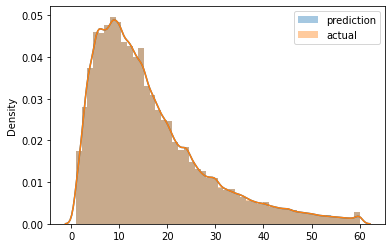

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

### Question 6. 

RMSE is very low, a little larger than training error. It is around $5\times10^{-7}$.

In [14]:
df_feb = pd.read_parquet("../data/fhv_tripdata_2021-02.parquet")

In [15]:
df_feb["duration"] = df_feb["dropOff_datetime"]-df_feb["pickup_datetime"]

df_feb["duration_minutes"] = df_feb["duration"]/ np.timedelta64(1, 'm')
df_feb['PUlocationID'] = df_feb['PUlocationID'].fillna(-1)
df_feb['DOlocationID'] = df_feb['DOlocationID'].fillna(-1)

df_feb = df_feb.dropna(subset=["duration_minutes"])


categorical = ['PUlocationID', 'DOlocationID']
numerical = ['duration_minutes']

df_feb[categorical] = df_feb[categorical].astype(str)



test_dict = df_feb[categorical + numerical].to_dict(orient='records')


In [16]:
target = "duration_minutes"
X_test = dv.transform(test_dict)
y_test = df_feb[target].values


y_pred_test = lr.predict(X_test)




4.981161291240708e-07


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


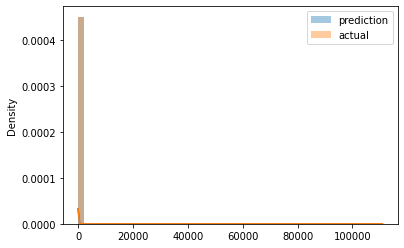

In [17]:
print(mean_squared_error(y_test, y_pred_test, squared=False))

sns.distplot(y_pred_test, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

Note: I know these values are much much smaller than what is being asked of us in the homework. However, that is my answer since I have not been able to find a source of error in the code. Feedback is much appreciated, thank you!